# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

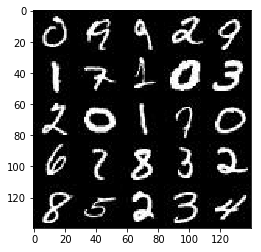

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

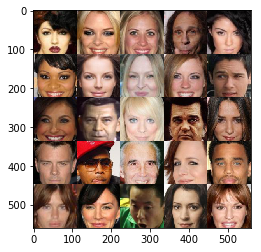

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 112, 112, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='image_input')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x28
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer, 28x28 x out_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_input, z_input, lr_input = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(image_input, z_input, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0 
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # Rescale from [-0.5, 0.5] to [-1, 1] 
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr_input:learning_rate})

                if steps % 50 == 0:
                    train_loss_d = d_loss.eval({image_input: batch_images, z_input:batch_z})
                    train_loss_g = g_loss.eval({z_input:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i + 1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 200 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 50... Discriminator Loss: 0.5041... Generator Loss: 2.7220
Epoch 1/2 Step 100... Discriminator Loss: 1.1203... Generator Loss: 0.8702
Epoch 1/2 Step 150... Discriminator Loss: 1.0066... Generator Loss: 2.6721
Epoch 1/2 Step 200... Discriminator Loss: 0.8354... Generator Loss: 1.4191


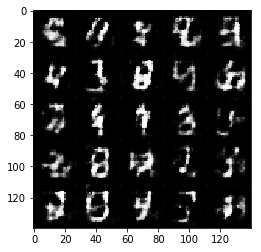

Epoch 1/2 Step 250... Discriminator Loss: 0.9568... Generator Loss: 1.3597
Epoch 1/2 Step 300... Discriminator Loss: 1.0461... Generator Loss: 0.9182
Epoch 1/2 Step 350... Discriminator Loss: 1.1743... Generator Loss: 0.6638
Epoch 1/2 Step 400... Discriminator Loss: 1.0190... Generator Loss: 0.9593


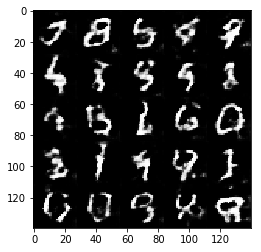

Epoch 1/2 Step 450... Discriminator Loss: 1.1143... Generator Loss: 1.3375
Epoch 1/2 Step 500... Discriminator Loss: 1.3567... Generator Loss: 0.5701
Epoch 1/2 Step 550... Discriminator Loss: 1.0744... Generator Loss: 1.2461
Epoch 1/2 Step 600... Discriminator Loss: 1.1032... Generator Loss: 0.7956


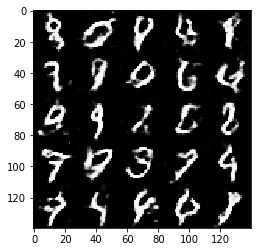

Epoch 1/2 Step 650... Discriminator Loss: 1.1729... Generator Loss: 0.7123
Epoch 1/2 Step 700... Discriminator Loss: 0.9503... Generator Loss: 1.3740
Epoch 1/2 Step 750... Discriminator Loss: 1.0095... Generator Loss: 0.9392
Epoch 1/2 Step 800... Discriminator Loss: 1.0073... Generator Loss: 1.0201


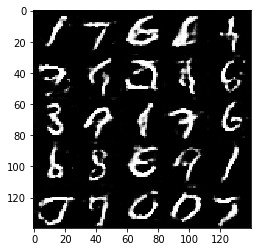

Epoch 1/2 Step 850... Discriminator Loss: 0.9407... Generator Loss: 0.9313
Epoch 1/2 Step 900... Discriminator Loss: 0.9019... Generator Loss: 1.4468
Epoch 2/2 Step 950... Discriminator Loss: 1.3022... Generator Loss: 0.5874
Epoch 2/2 Step 1000... Discriminator Loss: 1.0031... Generator Loss: 0.8476


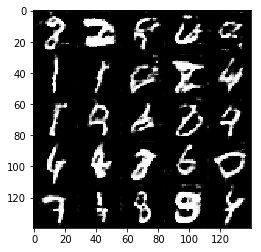

Epoch 2/2 Step 1050... Discriminator Loss: 0.9611... Generator Loss: 0.9199
Epoch 2/2 Step 1100... Discriminator Loss: 1.0774... Generator Loss: 1.9185
Epoch 2/2 Step 1150... Discriminator Loss: 1.1126... Generator Loss: 0.7832
Epoch 2/2 Step 1200... Discriminator Loss: 1.0351... Generator Loss: 0.7886


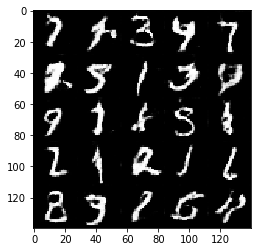

Epoch 2/2 Step 1250... Discriminator Loss: 1.0976... Generator Loss: 0.8877
Epoch 2/2 Step 1300... Discriminator Loss: 0.8298... Generator Loss: 2.1892
Epoch 2/2 Step 1350... Discriminator Loss: 0.8185... Generator Loss: 1.1244
Epoch 2/2 Step 1400... Discriminator Loss: 0.8702... Generator Loss: 2.4283


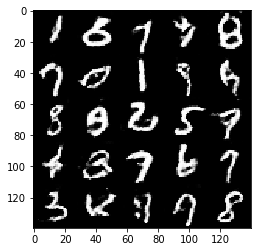

Epoch 2/2 Step 1450... Discriminator Loss: 2.6493... Generator Loss: 0.2164
Epoch 2/2 Step 1500... Discriminator Loss: 0.8696... Generator Loss: 1.7513
Epoch 2/2 Step 1550... Discriminator Loss: 0.9221... Generator Loss: 1.2037
Epoch 2/2 Step 1600... Discriminator Loss: 1.0419... Generator Loss: 0.8211


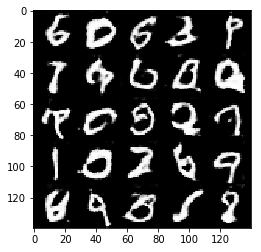

Epoch 2/2 Step 1650... Discriminator Loss: 1.4814... Generator Loss: 0.5366
Epoch 2/2 Step 1700... Discriminator Loss: 0.9025... Generator Loss: 1.0446
Epoch 2/2 Step 1750... Discriminator Loss: 0.7458... Generator Loss: 1.2536
Epoch 2/2 Step 1800... Discriminator Loss: 0.8253... Generator Loss: 1.2810


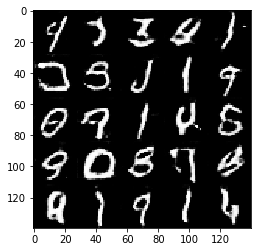

Epoch 2/2 Step 1850... Discriminator Loss: 0.6354... Generator Loss: 1.6804


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 50... Discriminator Loss: 0.5643... Generator Loss: 11.7435
Epoch 1/1 Step 100... Discriminator Loss: 0.9361... Generator Loss: 1.2680
Epoch 1/1 Step 150... Discriminator Loss: 1.0295... Generator Loss: 4.0940
Epoch 1/1 Step 200... Discriminator Loss: 1.5486... Generator Loss: 1.1305


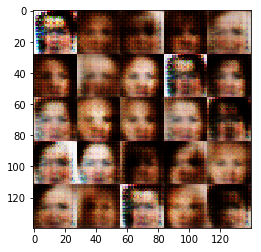

Epoch 1/1 Step 250... Discriminator Loss: 1.0222... Generator Loss: 1.1442
Epoch 1/1 Step 300... Discriminator Loss: 0.9424... Generator Loss: 1.2495
Epoch 1/1 Step 350... Discriminator Loss: 1.3016... Generator Loss: 0.7406
Epoch 1/1 Step 400... Discriminator Loss: 1.1069... Generator Loss: 1.0497


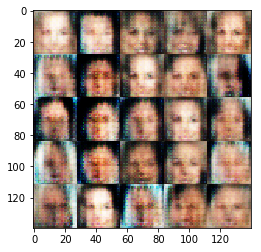

Epoch 1/1 Step 450... Discriminator Loss: 1.4247... Generator Loss: 0.6360
Epoch 1/1 Step 500... Discriminator Loss: 1.0204... Generator Loss: 2.1055
Epoch 1/1 Step 550... Discriminator Loss: 0.8919... Generator Loss: 1.7549
Epoch 1/1 Step 600... Discriminator Loss: 1.0139... Generator Loss: 1.1024


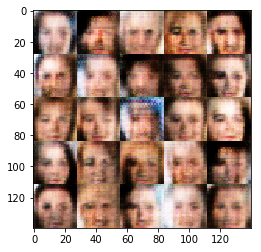

Epoch 1/1 Step 650... Discriminator Loss: 0.8708... Generator Loss: 1.8020
Epoch 1/1 Step 700... Discriminator Loss: 0.9121... Generator Loss: 0.9644
Epoch 1/1 Step 750... Discriminator Loss: 0.7471... Generator Loss: 1.8456
Epoch 1/1 Step 800... Discriminator Loss: 0.8359... Generator Loss: 1.3069


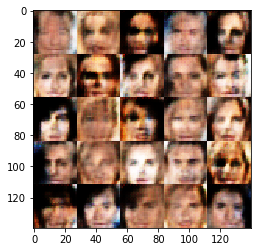

Epoch 1/1 Step 850... Discriminator Loss: 0.9444... Generator Loss: 3.2163
Epoch 1/1 Step 900... Discriminator Loss: 0.6821... Generator Loss: 2.0811
Epoch 1/1 Step 950... Discriminator Loss: 0.6153... Generator Loss: 1.6639
Epoch 1/1 Step 1000... Discriminator Loss: 1.1546... Generator Loss: 2.3366


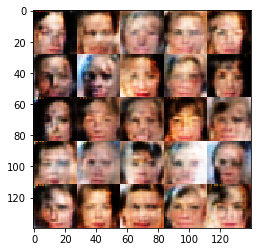

Epoch 1/1 Step 1050... Discriminator Loss: 2.0793... Generator Loss: 0.2398
Epoch 1/1 Step 1100... Discriminator Loss: 1.3581... Generator Loss: 0.6628
Epoch 1/1 Step 1150... Discriminator Loss: 0.6773... Generator Loss: 1.6667
Epoch 1/1 Step 1200... Discriminator Loss: 0.8931... Generator Loss: 1.1228


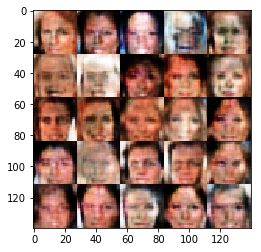

Epoch 1/1 Step 1250... Discriminator Loss: 1.1885... Generator Loss: 0.7201
Epoch 1/1 Step 1300... Discriminator Loss: 0.9839... Generator Loss: 0.9216
Epoch 1/1 Step 1350... Discriminator Loss: 0.6584... Generator Loss: 2.9815
Epoch 1/1 Step 1400... Discriminator Loss: 0.7424... Generator Loss: 1.3925


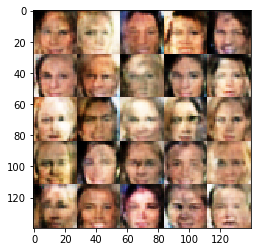

Epoch 1/1 Step 1450... Discriminator Loss: 0.7038... Generator Loss: 1.4324
Epoch 1/1 Step 1500... Discriminator Loss: 2.0610... Generator Loss: 0.3026
Epoch 1/1 Step 1550... Discriminator Loss: 0.7506... Generator Loss: 1.4282
Epoch 1/1 Step 1600... Discriminator Loss: 0.7385... Generator Loss: 2.7182


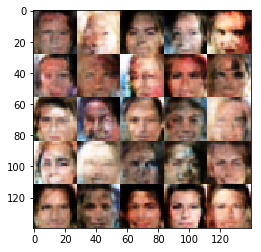

Epoch 1/1 Step 1650... Discriminator Loss: 1.3291... Generator Loss: 0.5854
Epoch 1/1 Step 1700... Discriminator Loss: 0.6433... Generator Loss: 3.1457
Epoch 1/1 Step 1750... Discriminator Loss: 0.6166... Generator Loss: 2.2183
Epoch 1/1 Step 1800... Discriminator Loss: 1.5968... Generator Loss: 0.4716


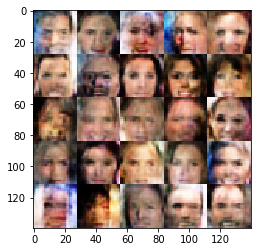

Epoch 1/1 Step 1850... Discriminator Loss: 0.5612... Generator Loss: 2.6674
Epoch 1/1 Step 1900... Discriminator Loss: 0.6173... Generator Loss: 2.8758
Epoch 1/1 Step 1950... Discriminator Loss: 0.9925... Generator Loss: 0.9466
Epoch 1/1 Step 2000... Discriminator Loss: 0.8146... Generator Loss: 2.7485


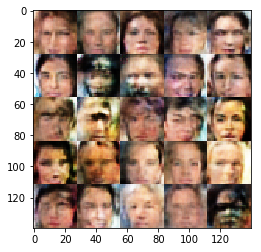

Epoch 1/1 Step 2050... Discriminator Loss: 0.6821... Generator Loss: 1.7094
Epoch 1/1 Step 2100... Discriminator Loss: 1.0211... Generator Loss: 0.8289
Epoch 1/1 Step 2150... Discriminator Loss: 0.9545... Generator Loss: 1.0415
Epoch 1/1 Step 2200... Discriminator Loss: 1.0717... Generator Loss: 3.1268


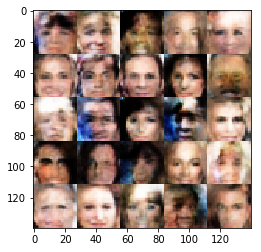

Epoch 1/1 Step 2250... Discriminator Loss: 0.6775... Generator Loss: 1.4891
Epoch 1/1 Step 2300... Discriminator Loss: 0.4356... Generator Loss: 3.5032
Epoch 1/1 Step 2350... Discriminator Loss: 0.7340... Generator Loss: 1.6483
Epoch 1/1 Step 2400... Discriminator Loss: 0.4941... Generator Loss: 2.8998


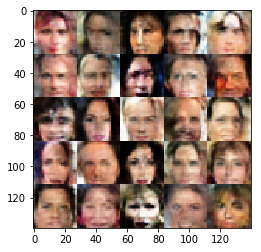

Epoch 1/1 Step 2450... Discriminator Loss: 0.8414... Generator Loss: 1.3791
Epoch 1/1 Step 2500... Discriminator Loss: 0.5534... Generator Loss: 3.6344
Epoch 1/1 Step 2550... Discriminator Loss: 0.6127... Generator Loss: 2.4561
Epoch 1/1 Step 2600... Discriminator Loss: 0.9187... Generator Loss: 2.0254


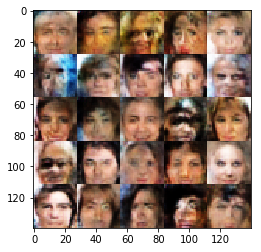

Epoch 1/1 Step 2650... Discriminator Loss: 1.5379... Generator Loss: 0.5184
Epoch 1/1 Step 2700... Discriminator Loss: 0.7260... Generator Loss: 1.6094
Epoch 1/1 Step 2750... Discriminator Loss: 0.5780... Generator Loss: 1.9455
Epoch 1/1 Step 2800... Discriminator Loss: 0.7053... Generator Loss: 2.7346


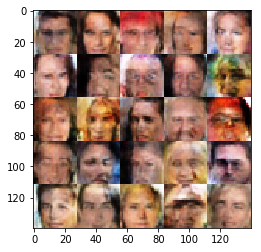

Epoch 1/1 Step 2850... Discriminator Loss: 1.4124... Generator Loss: 2.7092
Epoch 1/1 Step 2900... Discriminator Loss: 1.2100... Generator Loss: 0.7481
Epoch 1/1 Step 2950... Discriminator Loss: 0.5054... Generator Loss: 2.5952
Epoch 1/1 Step 3000... Discriminator Loss: 0.8755... Generator Loss: 1.3529


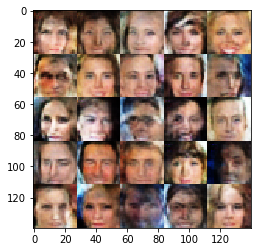

Epoch 1/1 Step 3050... Discriminator Loss: 0.4528... Generator Loss: 3.0449
Epoch 1/1 Step 3100... Discriminator Loss: 0.9155... Generator Loss: 2.0027
Epoch 1/1 Step 3150... Discriminator Loss: 0.4261... Generator Loss: 3.2498


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.